# Generate Paper Plots

In [1]:
from eval_model_helpers import *
sys.path.append(os.path.join('..'))
from models.func_to_func2d_invasive import FNO2d
from util.utilities_module import *
from gen_GRF import *
import torch
import matplotlib.pyplot as plt

import matplotlib
import numpy as np

#### Set plot defaults

In [2]:
# Plot defaults
# Set font default
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'custom'
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00',
                    '#000000']
matplotlib.rcParams['mathtext.rm'] = 'stix'
matplotlib.rcParams['mathtext.it'] = 'stix'
matplotlib.rcParams['mathtext.bf'] = 'stix'


matplotlib.rcParams["axes.formatter.limits"] = (-99, 99) #makes scientific notation threshold high
plt.rcParams['font.family'] = 'serif'  # or 'DejaVu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']  # 'DejaVu Serif' 'serif' 'Times

tickfontsize = 40
fontsize = 40
linewidth = 4
markersize = 15

SMALL_SIZE = tickfontsize
MEDIUM_SIZE = tickfontsize
BIGGER_SIZE = fontsize

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

shapes = ['o','s','^','D','*', 'x', 'P', 'h', 'v', '<', '>', 'X', 'd', 'p', '|', '_', '.', ',']


#### Set parameters

In [3]:
s_vals = [0.5, 1.0, 1.5, 2.0]
sizes = [64, 128, 256, 512] #, 1024]
plot_sizes = sizes[:-1]

#### Error evaluation function for each layer

In [4]:
def get_err_norms_trained(s,model_name, sizes = [32, 64, 128, 256],dup_input = True):

    model_info_path = '../models/trained_models/' + model_name + '_info.yaml'
    model_path = '../models/trained_models/' + model_name + '.pt'

    USE_CUDA = torch.cuda.is_available()
    samp_count_input = 2
    true_size = sizes[-1]
  
    # Load model
    model = load_model(model_info_path, model_path,s_outputspace = (true_size,true_size))
    
    model_info = load_model_info(model_info_path)
    n_layers = model_info['n_layers']-1

    true_norms = torch.zeros(n_layers, samp_count_input)
    all_err = torch.zeros(len(sizes)-1,n_layers, samp_count_input)

    if dup_input:
        channel_count = 3
    else:
        channel_count = 1
    true_inputs = torch.zeros(samp_count_input,channel_count,true_size,true_size)
    for input_i in range(samp_count_input):
        true_input_path = '../data/GRF_s' + str(s) +'_GRF_size_' + str(true_size) + '_' + str(input_i)+ '.pkl'
        input_true = load_data(true_input_path)
        input_true = input_true.unsqueeze(0).unsqueeze(0)
        if dup_input:
            # duplicate along axis 1
            input_true = input_true.repeat(1,3,1,1)
            # set middle channel to 0
            input_true[:,1] = 0
        else:
            pass
        true_inputs[input_i,:] = input_true
    
    layers_true = get_layer_output(model,true_inputs)

    for size_i, size in enumerate(sizes[:-1]):
        disc_inputs = torch.zeros(samp_count_input,channel_count,size,size)
        for input_i in range(samp_count_input):
            disc_input_path = '../data/GRF_s' +str(s) + f'_GRF_size_{size}_'+ str(input_i)+'.pkl'
            input_disc = load_data(disc_input_path)
            input_disc = input_disc.unsqueeze(0).unsqueeze(0)
            if dup_input:
                input_disc = input_disc.repeat(1,3,1,1)
                input_disc[:,1] = 0
            else:
                pass
            disc_inputs[input_i,:] = input_disc
        layers_disc = get_layer_output(model,disc_inputs)
        for input_i in range(samp_count_input):
            for layer in range(n_layers):
                err = torch.norm(layers_disc[layer][input_i] - layers_true[layer][input_i])
                all_err[size_i,layer, input_i] = err
                true_norms[layer, input_i] = torch.norm(layers_true[layer][input_i])

    all_err = all_err.detach().numpy()
    true_norms = true_norms.detach().numpy()
    all_err = all_err.reshape(len(sizes)-1,n_layers,samp_count_input)

    return all_err, true_norms


In [5]:
def evaluate_model_trained(model_name,s_vals,sizes,dup_input = True):
    all_err_s = []
    true_norms_s = []
    for s in s_vals:
        all_err, true_norms = get_err_norms_trained(s,model_name,sizes=sizes,dup_input=dup_input)
        all_err_s.append(all_err)
        true_norms_s.append(true_norms)

    true_norms_s = np.array(true_norms_s)
    all_err_s = np.array(all_err_s)
    return all_err_s, true_norms_s

In [6]:
def normalize_err(all_err_s,true_norms_s):
    # Normalize all_err_s by true_norms_s
    n_layers = true_norms_s.shape[1]
    all_err_s = np.array(all_err_s)
    n_samples = all_err_s.shape[-1]
    all_err_s_norm = np.zeros((len(s_vals),len(plot_sizes),n_layers,n_samples))
    for i in range(len(s_vals)):
        for j in range(n_layers):
            all_err_s_norm[i,:,j,:] = all_err_s[i,:,j,:] / true_norms_s[i,j,0]
    return all_err_s_norm

In [7]:
def plot_err_vs_N(all_err_s_norm,plot_sizes,plot_name):
    fix, ax = plt.subplots(1,4, figsize=(40, 10))

    for i, s in enumerate(s_vals):
        all_err = all_err_s_norm[i]

        all_err_mean = np.mean(all_err, axis = -1)
        all_err_std = 2*np.std(all_err, axis = -1)

        slopes = []

        for layer in range(all_err.shape[1]):
            ax[i].plot(plot_sizes,all_err_mean[:,layer],label = f'Layer {layer+1}',color = CB_color_cycle[layer],marker = shapes[layer],linewidth = linewidth,markersize = markersize)
            ax[i].errorbar(plot_sizes, all_err_mean[:,layer], yerr=all_err_std[:,layer],color = CB_color_cycle[layer])
            ax[i].fill_between(plot_sizes, all_err_mean[:,layer] - all_err_std[:,layer], all_err_mean[:,layer] + all_err_std[:,layer], alpha=0.2, color = CB_color_cycle[layer])

            p = np.polyfit(np.log(plot_sizes), np.log(all_err_mean[:,layer]), 1)
            slopes.append(p[0])

        ax[i].set_title('s = ' + str(s) + f',    Average Slope = {np.mean(slopes):.2f}') 
        # logscale
        ax[i].set_yscale('log')
        # set y range
        ax[i].set_ylim([np.min(all_err_s_norm)/2, np.max(all_err_s_norm)*2])
        ax[i].set_xscale('log') 
        ax[i].set_xlabel('N')
        ax[i].set_xticks([])
        ax[i].xaxis.set_minor_locator(plt.NullLocator())

        # no scientific notation x labels

        ax[i].set_xticks(plot_sizes, plot_sizes)
    ax[0].set_ylabel('Relative Error') 
    ax[0].legend()
    ax[3].legend()
    # save figure
    plt.savefig('../Figures/' + plot_name + '.pdf')

## Smooth Experiments

### X-Y Grid

In [58]:
# Load config file
config_name = 'smooth_x_y_grid'
config_path = '../models/trained_models/' + config_name + '_info.yaml'
with open(config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

# Load input and output data
input_data_smooth = torch.load('../data/smooth_training_data/A_to_chi1_tiny_input_data.pt')
output_data_smooth = torch.load('../data/smooth_training_data/A_to_chi1_tiny_output_data.pt')

model_name = config['model_name']

In [59]:
all_err_s_xy, true_norms_s_xy = evaluate_model_trained(model_name,s_vals,sizes)
all_err_s_norm_xy = normalize_err(all_err_s_xy,true_norms_s_xy)

Device: cpu
Device: cpu
Device: cpu
Device: cpu


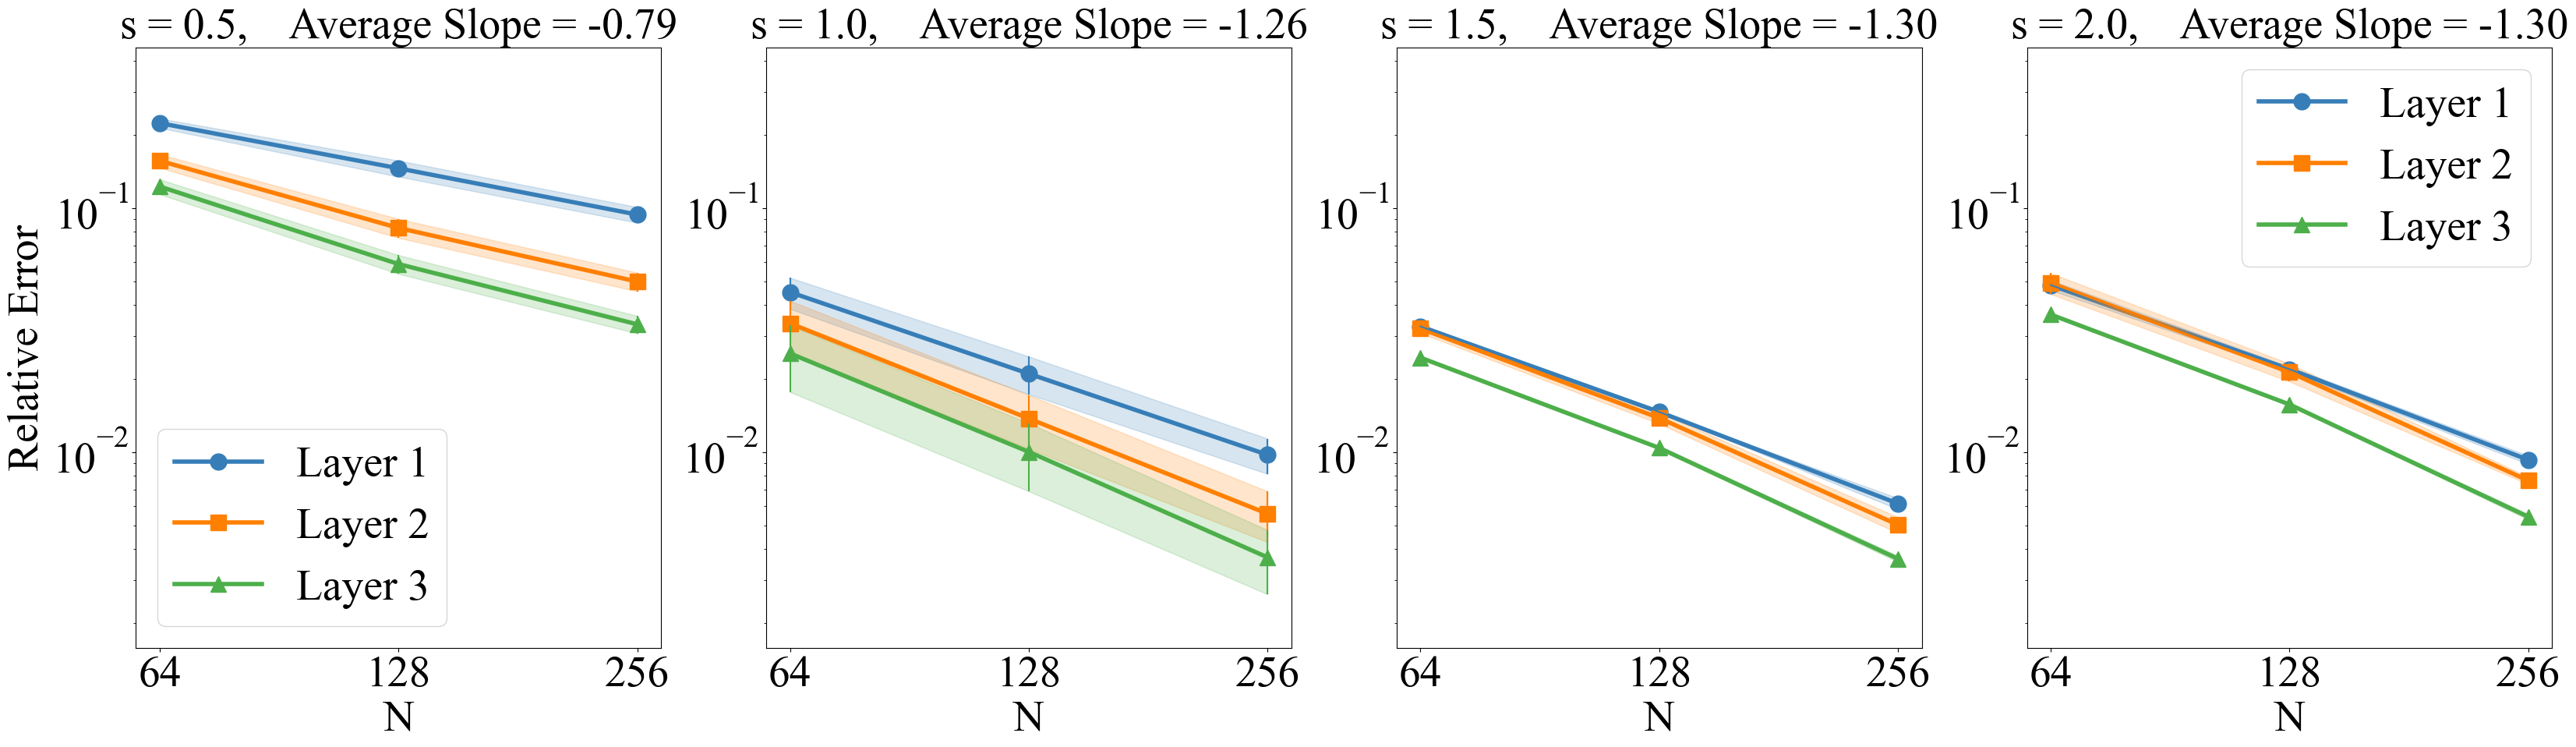

In [60]:
plot_err_vs_N(all_err_s_norm_xy,plot_sizes,'err_vs_N_trained_smooth_xy')

### Periodic Grid

In [61]:
model_name = 'smooth_periodic_grid'
all_err_smooth_per, true_norms_smooth_per = evaluate_model_trained(model_name,s_vals,sizes)
all_err_s_norm_smooth_per = normalize_err(all_err_smooth_per,true_norms_smooth_per)


Device: cpu
Device: cpu
Device: cpu
Device: cpu


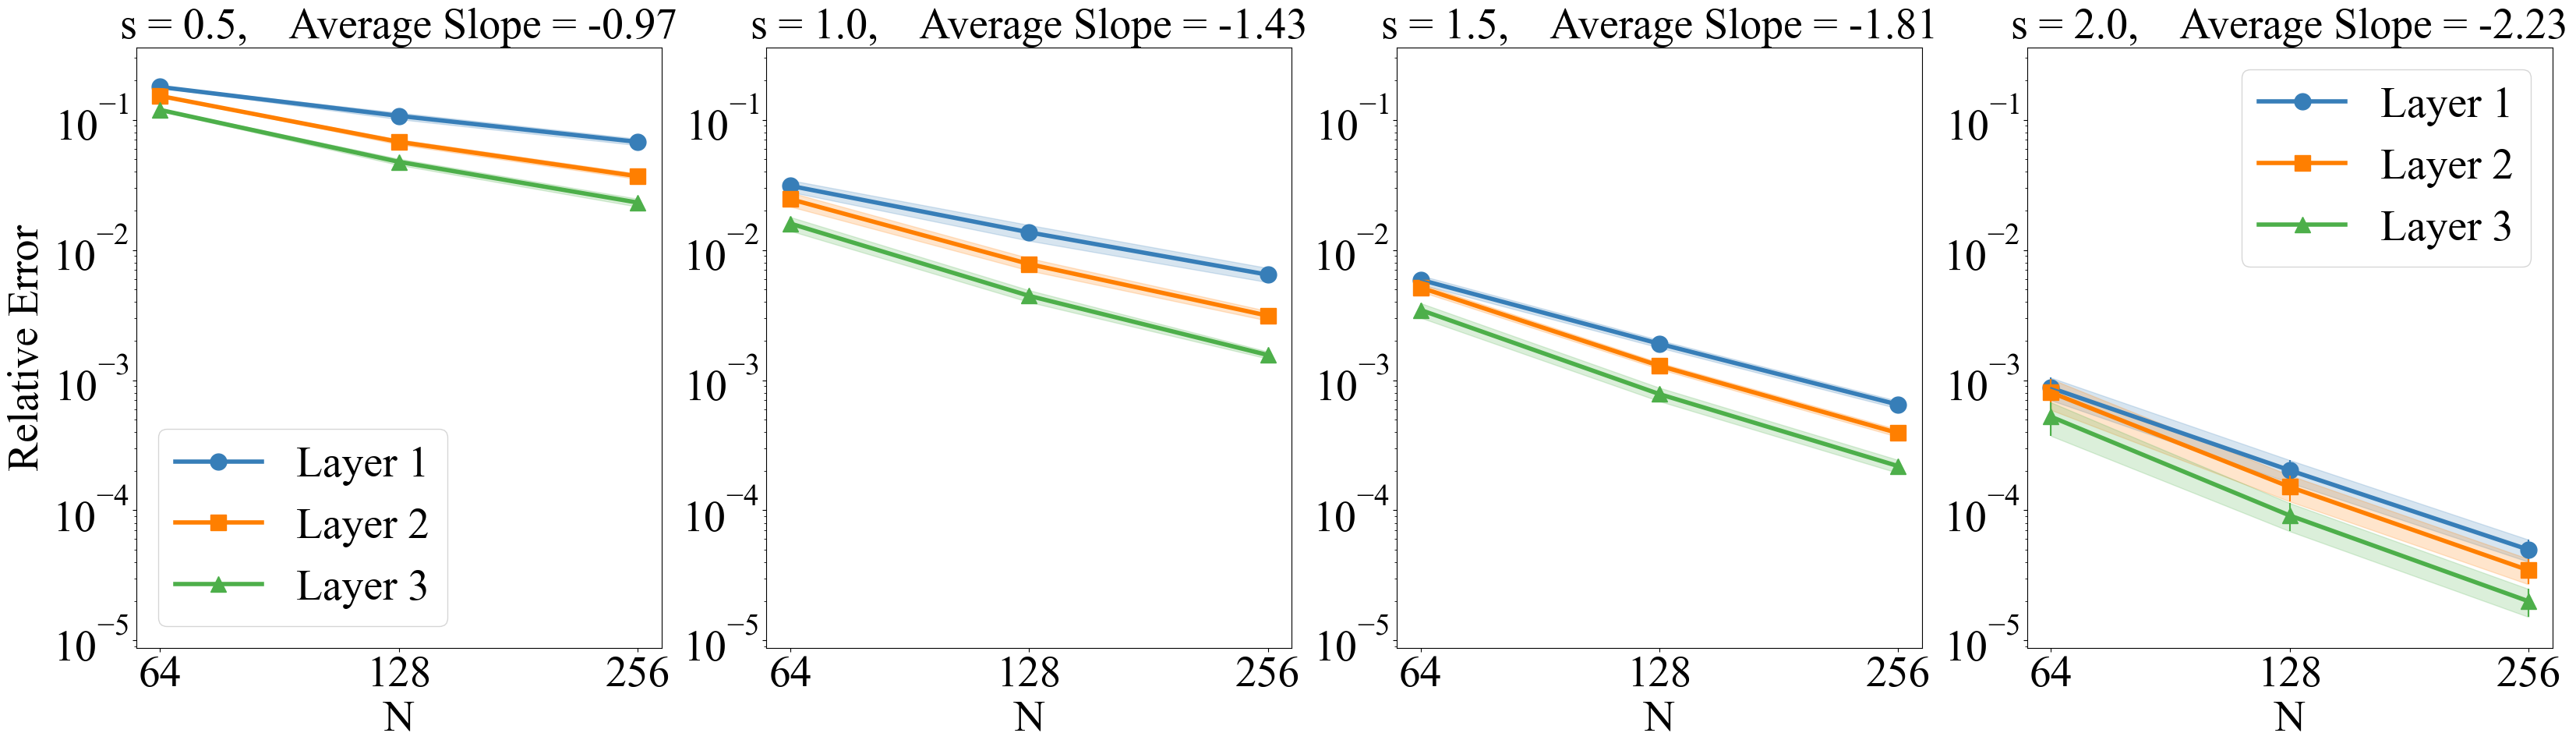

In [62]:
plot_err_vs_N(all_err_s_norm_smooth_per,plot_sizes,'err_vs_N_trained_smooth_xy')

## Grad Problem

In [8]:
# Load input and output data
input_data_grad = torch.load('../data/grad_training_data/input_data_grad_tiny.pt')
output_data_grad = torch.load('../data/grad_training_data/output_data_grad_tiny.pt')

In [9]:
model_name = 'grad_x_y_grid' 
all_err_grad_xy, true_norms_grad_xy = evaluate_model_trained(model_name,s_vals,sizes,dup_input = False)
all_err_s_norm_grad_xy = normalize_err(all_err_grad_xy,true_norms_grad_xy)

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


findfont: Font family ['stix'] not found. Falling back to DejaVu Sans.


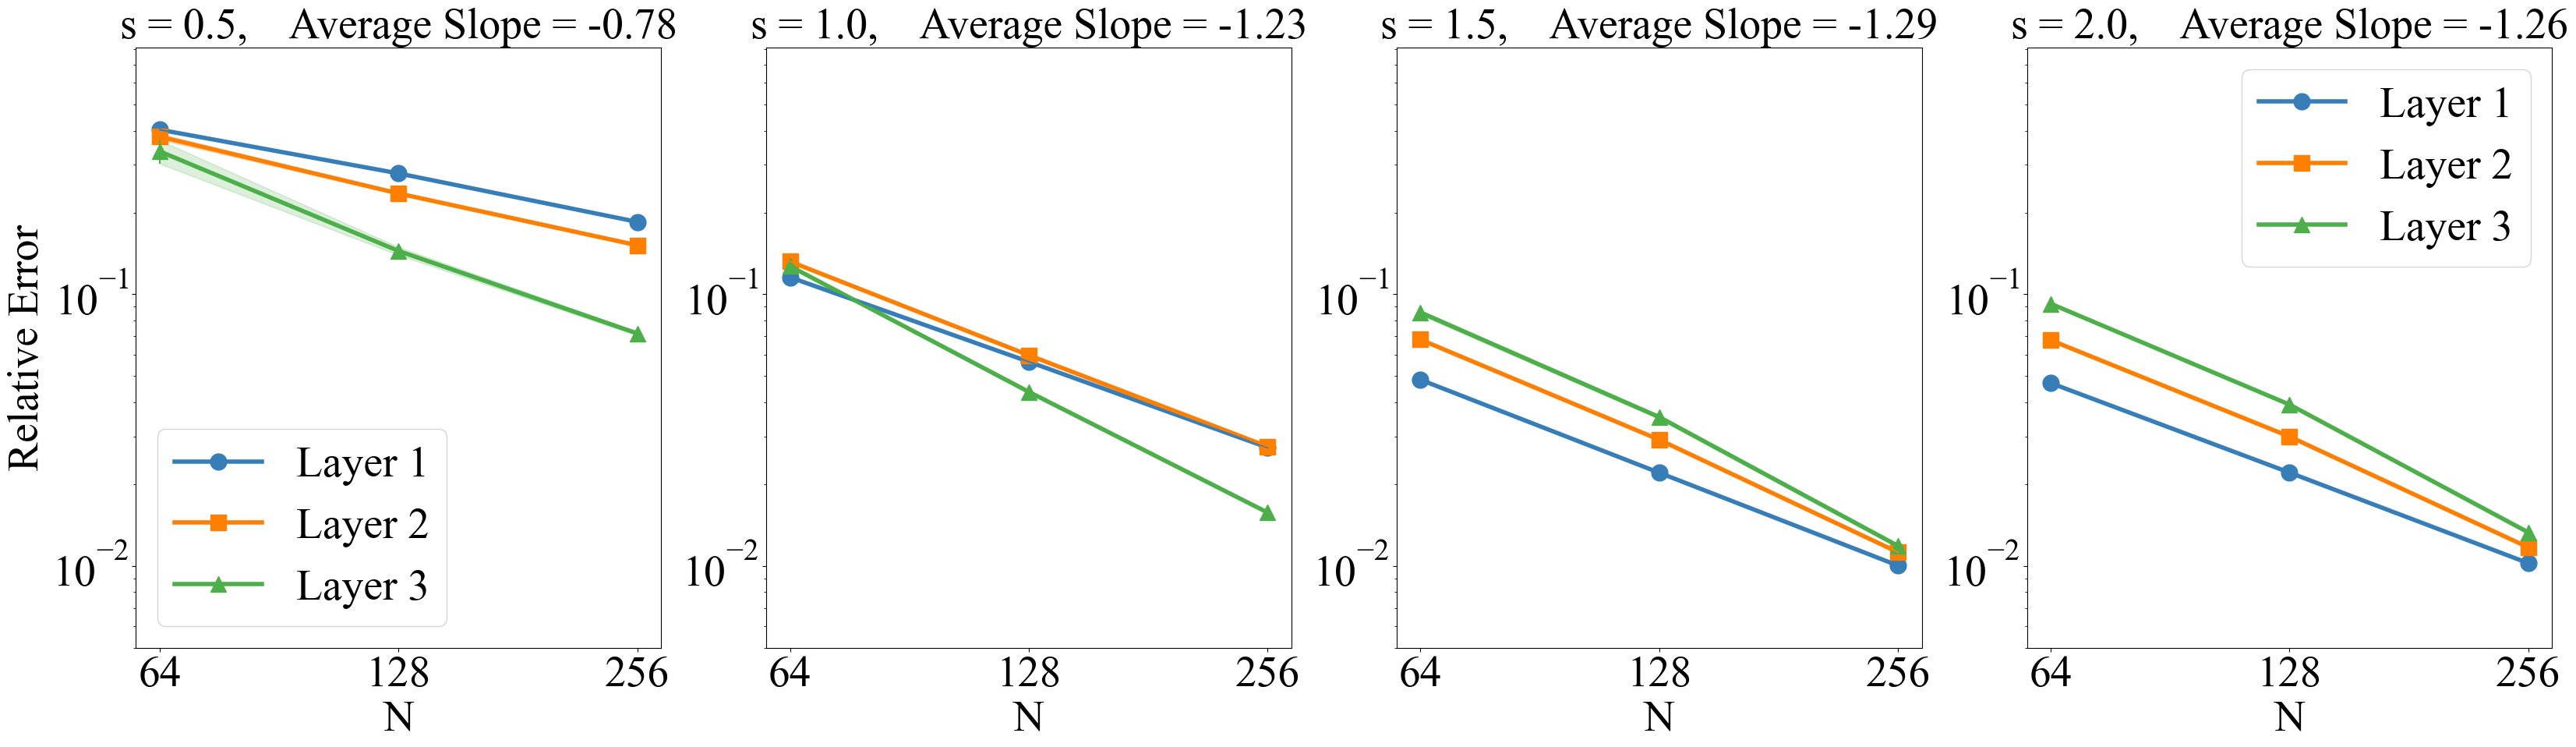

In [10]:
plot_err_vs_N(all_err_s_norm_grad_xy,plot_sizes,'err_vs_N_trained_grad_xy')

### Periodic grid

In [ ]:
model_name = 'grad_periodic_grid'
all_err_grad_per, true_norms_grad_per = evaluate_model_trained(model_name,s_vals,sizes,dup_input = False)
all_err_s_norm_grad_per = normalize_err(all_err_grad_per,true_norms_grad_per)

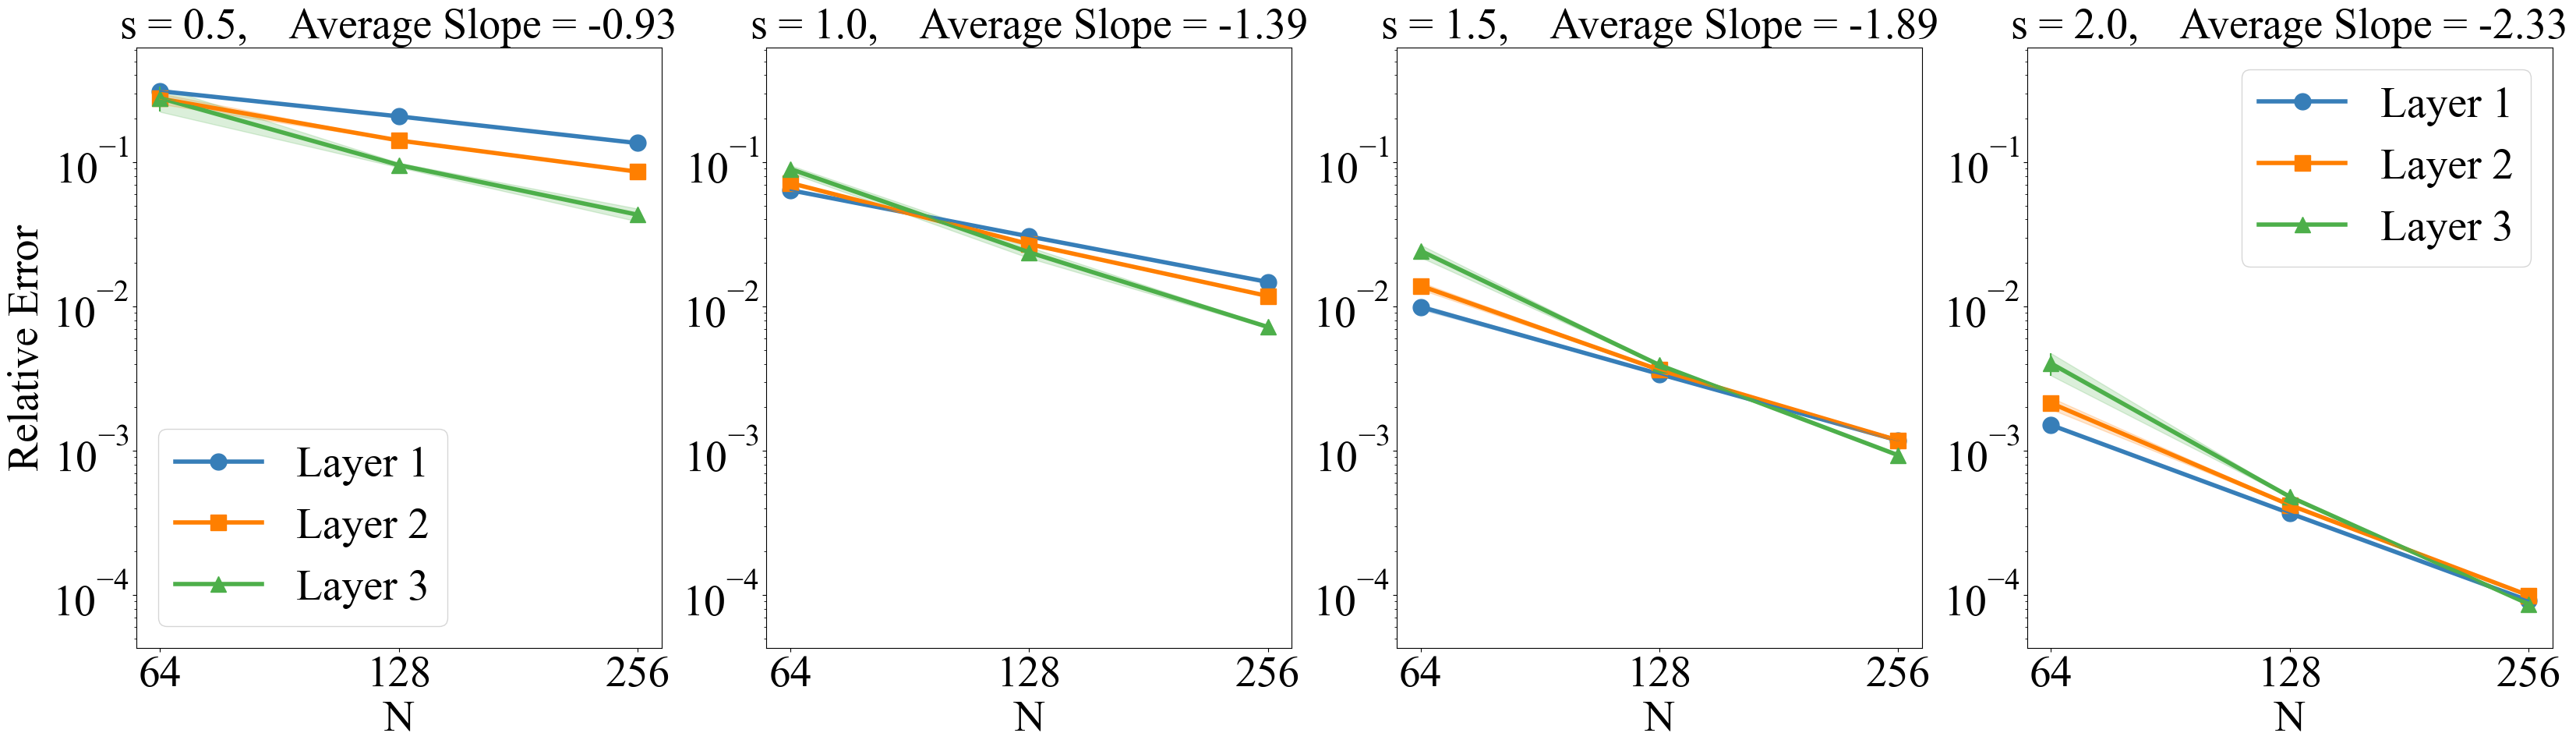

In [34]:
plot_err_vs_N(all_err_s_norm_grad_per,plot_sizes,'err_vs_N_trained_grad_per')